## Party Manifesto 'Redistributiveness' vs Electorate Income

In [1]:
# from IPython.display import display
# from IPython.display import HTML
# import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# # This line will hide code by default when the notebook is exported as HTML
# di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# # This line will add a button to toggle visibility of code blocks, for use with the HTML export version
# di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

In [2]:
%%time
%matplotlib inline
%run Prosser_header.py

dataset_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\datasets\\"
output_folder  = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\output\\"

Toggle code

Wall time: 4.24 s


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, os
import pickle

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show,  output_notebook
from bokeh.layouts import column, row
from bokeh.embed import components
from bokeh.transform import factor_cmap
from bokeh.models import HoverTool
from bokeh.models import Span, Label
from bokeh.models import BoxAnnotation


output_notebook()

Loading BokehJS ...

In [4]:
def weighted_mean(x, **kws):
    val, weight = map(np.asarray, zip(*x))
    val, weight = val[~np.isnan(val)],weight[~np.isnan(val)]
    return (val * weight).sum() / weight.sum()

flatten = lambda l: [item for sublist in l for item in sublist]

In [5]:
dataset_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\datasets\\"
output_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\output\\"

Manifesto_Project_Dataset_version_2019b = "MPDataset_MPDS2019b_stata14.dta"

manifest_project = pd.read_pickle(dataset_folder+Manifesto_Project_Dataset_version_2019b.replace("dta","zip"),compression='zip')
with open(Manifesto_Project_Dataset_version_2019b.replace("dta","_labels.zip"), 'rb') as fname:
    ESS_labels = pickle.load(fname)
with open(Manifesto_Project_Dataset_version_2019b.replace("dta","_header.zip"), 'rb') as fname:
    ESS_header = pickle.load(fname)


EuropeanSocialSurvey9_2018_v2_integrated = "ESS9e02.dta"

ESS = pd.read_pickle(dataset_folder+EuropeanSocialSurvey9_2018_v2_integrated.replace("dta","zip"),compression='zip')
with open(EuropeanSocialSurvey9_2018_v2_integrated.replace("dta","_labels.zip"), 'rb') as fname:
    ESS_labels = pickle.load(fname)
with open(EuropeanSocialSurvey9_2018_v2_integrated.replace("dta","_header.zip"), 'rb') as fname:
    ESS_header = pickle.load(fname)

# Early Version using Manifesto Project Redistribution Support data and ESS 9 party supporter income data (manually linked!)

###### Income data 2018-2019, Party support for Redistribution most recent in CMP dataset (for major parties, most recent GE - for minor parties could be decades old!)

###### Appropriate as v rough overview

###### Support For Redistribution = Sum of % of positive references to redistribution/welfare
###### Support Base Affluence = (weighted) mean of party supporter income quintile

In [6]:
## Manual linkage of ESS party vote to CMP ids

min_voter_sample_size = 100

## ess party vote variables
vote_vars = ['prtvtcat',
 'prtvtdbe',
 'prtvtdbg',
 'prtvtgch',
 'prtvtbcy',
 'prtvtecz',
#  'prtvede1',
 'prtvede2',
 'prtvtgee',
 'prtvtees',
 'prtvtdfi',
 'prtvtdfr',
 'prtvtcgb',
 'prtvtahr',
 'prtvtfhu',
 'prtvtcie',
 'prtvtcit',
 'prtvblt1',
#  'prtvblt2',
#  'prtvblt3',
 'prtvtalv',
 'prtvtme',
 'prtvtgnl',
 'prtvtbno',
 'prtvtdpl',
 'prtvtcpt',
 'prtvtrs',
 'prtvtcse',
 'prtvtfsi',
 'prtvtdsk']

# this was tedious - and will have to update if looking at different period/reduce sample size!
ESS_big_parties_to_CMP_parties = {'Ã\x96VP':42520, 'SPÃ\x96':42320, 'FPÃ\x96':42420, 'GrÃ¼ne':42110,#Austria
 'N-VA':21916, 'PS':21322, 'CD&V':21521,  'MR':21426,#Belgium
 'Grazhdani za evropeiÌ\x86sko razvitie na Bulgariya (GERB)':80510,
       'Balgarska sotsialisticheska partiya (BSP)':80220,
       'Dvizhenie za prava i svobodi (DPS)':80951,#Bulgaria 
       'Social Democratic Party / Socialist Party':43320, 'FDP. The Liberals':43420,
           "Swiss People's Party":43810,#Swizterland
       'Democratic Rally (DISY)':55711,#Cyprus
       'ANO 2011':82430,'ODS':82413, 'Ä\x8cSSD':82320,
         'Ä\x8ceskÃ¡ pirÃ¡tskÃ¡ strana':82953, 'KSÄ\x8cM':82220,#Czechia
       'Christian Democratic Union/Christian Social Union (CDU/CSU)':41521,
           'Social Democratic Party (SPD)':41320,
           'Alliance 90/The Greens (BÃ¼ndnis 90/Die GrÃ¼nen)':41113,
           'Free Democratic Party (FDP)':41420, 'The Left (Die Linke)':41223,
           'Alternative for Germany (AFD)':41953,#Germany
       'Eesti Reformierakond':83430,
       'Eesti Keskerakond':83411, 'Sotsiaaldemokraatlik Erakond':83410,
       'Erakond Isamaa ja Res Publica Liit':83611,#Estonia
       'PSOE':33320, 'PP':33610,'Unidas Podemos':33210, 'VOX':np.nan,#Spain
       'The National Coalition Party':14620,
           'The Centre Party':14810, 'Social Democratic Party':14320, 'Green League':14110,
           'True Finns':14820,#Finland
     'LREM (LA RÃ\x89PUBLIQUE EN MARCHE)':31425,
       'LR (LES RÃ\x89PUBLICAINS)':31626, 'PS (Parti Socialiste)':31320,
       'FN (Front National)':31720,#France
         'Conservative':51620, 'Labour':51320, 'Liberal Democrat':51421,#United Kingdom
 'Narodna koalicija - SDP, HNS, HSU, HSS':81032,  'Hrvatska demokratska zajednica (HDZ)':81711,#Croatia
       'Fidesz (Fidesz Magyar PolgÃ¡ri PÃ¡rt)':86421,
       'Jobbik (Jobbik MagyarorszÃ¡gÃ©rt Mozgalom)':86710,
       'MSZP (Magyar Szocialista PÃ¡rt)':86320,#Hungary
 'Fine Gael':53520, 'Fianna FÃ¡il':53620,
       'Independent':53981, 'Sinn FÃ©in':53951,#Ireland
 'Movimento 5 Stelle':32956,
       'Partido Democratico (PD)':32440, 'Lega Nord':32720,#Italy
       'Lithuanian Peasant and Greens Union (LVZS)':88820,
       'Homeland Union - Lithuanian Christian Democrats (TS-LKD)':88621,
       'Lithuanian Social Democratic Party (LSDP)':88320,#Lithuania
 
       'DPS - Milo Ä\x90ukanoviÄ\x87':91220,#Montenegro
 
       "People's Party for Freedom and Democracy":22955, "Democrats '66":22330,
       'Green Left':22110, 'Christian Democratic Appeal':22521,#Netherlands
 'HÃ¸yre':12620,
       'Arbeiderpartiet':12320, 'Fremskrittspartiet':12951,#Norway
       'Prawo i SprawiedliwoÅ\x9bÄ\x87':92436, 'Platforma Obywatelska':92435,#Poland
       'PS - Partido Socialista':35311,
       'PPD-PSD/CDS-PP - Portugal Ã\xa0 Frente':35313,#Portugal
       'Aleksandar VuÄ\x8diÄ\x87-Srbija pobeÄ\x91uje':95071,#Serbia
       'Socialdemokraterna':11320, 'Moderata samlingspartiet':11620, 'Centern':11810,
       'Sverigedemokraterna':11710, 'VÃ¤nsterpartiet':11220,#Sweden
       'SDS - Slovenska demokratska stranka':97330,
       'LMÅ\xa0 - Lista Marjana Å\xa0arca':np.nan,#Slovenia
 'Smer â\x80\x93 SD':96423#Slovakia]
}


votes_country_dict = {x:re.sub("Party voted for in last national election\s?\d?, ","",ESS_header[x])\
                      .replace('France (ballot 1)',"France")\
                      .replace('Ireland (derived from 1st preference','Ireland')\
                      .replace('Lithuania (first vote, party)','Lithuania')
                      for x in vote_vars}

big_parties_by_country_dict = {}
for vote_var in votes_country_dict.keys():
    big_parties_by_country_dict[ votes_country_dict[vote_var] ] = list(ESS[vote_var].value_counts()[ESS[vote_var].value_counts()>=min_voter_sample_size].index)
big_parties_by_country_dict


# ESS[list(votes_country_dict.keys())].notnull().sum(axis=1).sort_values()
# note - checked, there's no overlap between different elections!

# get the overlap set for parties in both datasets who were in the most recent election
ESS_big_party_list_overlap = [x for x in ESS_big_parties_to_CMP_parties.keys() if pd.notnull(ESS_big_parties_to_CMP_parties[x])]
party_voted_in_last_nat_election = ESS[list(votes_country_dict.keys())].fillna(axis=1,method ='ffill')[list(votes_country_dict.keys())[-1]]
party_voted_in_last_nat_election.loc[party_voted_in_last_nat_election.apply(lambda x: x not in ESS_big_party_list_overlap)] = np.nan

# this is ... a bit much for one line!
voting_country = ESS[list(votes_country_dict.keys())].notnull().idxmax(axis=1).map(votes_country_dict)
voting_country.loc[party_voted_in_last_nat_election.apply(lambda x: x not in ESS_big_party_list_overlap)] = np.nan



In [7]:
## ESS income decile data

deciles = ESS['hinctnta'].cat.codes.replace(-1,np.nan)
ESS["income_deciles_wts"] = list(zip(deciles,ESS["pspwght"]))
weighted_income_deciles_by_party = ESS["income_deciles_wts"].groupby(party_voted_in_last_nat_election).agg(weighted_mean).sort_values().reset_index()
weighted_income_deciles_by_party.columns = ["party","mean_inc_decile"]
# weighted_income_deciles_by_party

In [8]:
#### FILTER BY PROGRAMME TYPE! (good to remember, but prob obsolete since we won't be relying on upon just the CMP measure long-term)

In [9]:
# another shocking single line function
cmp_overlap_df = manifest_project[manifest_project["party"].apply(lambda x: x in ESS_big_parties_to_CMP_parties.values())].sort_values(by="edate").groupby("party").last()
cmp_overlap_df = cmp_overlap_df.sort_index()

In [10]:
# "redistributiveness" measure
manifesto_redist = cmp_overlap_df[["per"+x for x in ["404","405","409","413","504","701"]]].sum(axis=1)

In [11]:
weighted_income_deciles_by_party["party"] = weighted_income_deciles_by_party["party"].map(ESS_big_parties_to_CMP_parties)
weighted_income_deciles_by_party = weighted_income_deciles_by_party.set_index("party")
weighted_income_deciles_by_party = weighted_income_deciles_by_party["mean_inc_decile"].sort_index()

In [12]:
cmp_overlap_df["weighted_income_deciles"] = weighted_income_deciles_by_party
cmp_overlap_df["manifesto_redist"] = manifesto_redist

cmp_overlap_df["partyabbrev_filled"] = cmp_overlap_df["partyabbrev"].astype('object')
cmp_overlap_df.loc[cmp_overlap_df["partyabbrev"]=="","partyabbrev_filled"] = cmp_overlap_df[cmp_overlap_df["partyabbrev"]==""]["partyname"].astype('object')

In [13]:
party_colour_dict = {'eco ecologist':'green', 'lef socialist or other left':'pink', 'soc social democratic':'red',
       'lib liberal':'orange', 'chr christian democrat':'darkblue', 'con conservative':'lightblue',
       'nat nationalist':'purple', 'agr agrarian':'brown', 'eth ethnic-regional':'yellow',
       'sip special issue':'olive','dummy divers alliance':'black','dummy missing information':'grey'}

# {'divers alliance', 'missing information'}

In [14]:
cmp_overlap_df["Party Family"] = cmp_overlap_df["parfam"].apply(lambda x: (" ").join(x.split(" ")[1:]))
party_colour_dict = {(" ").join(k.split(" ")[1:]):v for k,v in party_colour_dict.items()}

In [15]:
## give the axes slightly more human legible names

x_axis = "Support Base Affluence"
y_axis = "Support For Redistribution"
cmp_overlap_df = cmp_overlap_df.rename(columns={"weighted_income_deciles":x_axis,"manifesto_redist":y_axis})


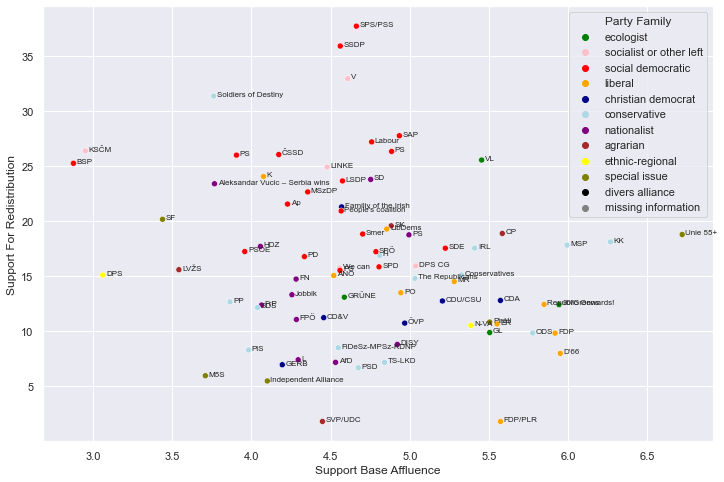

In [16]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = cmp_overlap_df,x=x_axis,y=y_axis,
                hue="Party Family",palette=party_colour_dict);

# make size = percentage of the vote? "pervote"

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=8)

label_point(cmp_overlap_df[x_axis],
            cmp_overlap_df[y_axis],
            cmp_overlap_df["partyabbrev_filled"], plt.gca())

plt.xlabel(x_axis);
plt.ylabel(y_axis);
# plt.gca().legend(title='Party Family');

In [17]:
cmp_overlap_df["parfam"] = cmp_overlap_df["parfam"].cat.remove_unused_categories()
# cmp_overlap_df["parfam"].value_counts()
cmp_overlap_df["pervote_smaller"] = cmp_overlap_df["pervote"]/2

In [18]:

# colours = mps["party"].replace(party_colour_dict).values
colors = factor_cmap('Party Family', palette=list(party_colour_dict.values()), factors=list(party_colour_dict.keys()))

hover = HoverTool(tooltips = [('name','@partyname'),
                              ('party family','@{Party Family}'),
                              ('country','@countryname'),
                              ('date','@date'),
                              ('right-left','@rile'),
                              ('planned economy','@planeco'),
                              ('market economy','@markeco'),
                              ('welfare','@welfare'),
                              ('intpeace','@intpeace')])

p1 = figure(plot_width=950, plot_height=400, title="Party Manifesto 'Redistributiveness' by Mean Electorate Income Decile",
            tools='box_select,pan,wheel_zoom,box_zoom,reset', active_drag="box_select",
            x_axis_label = x_axis,y_axis_label=y_axis,)
for family in cmp_overlap_df["Party Family"].cat.categories:
    mask = cmp_overlap_df["Party Family"]==family
    source = ColumnDataSource(cmp_overlap_df[mask])
    p1.scatter(x_axis, y_axis, source=source,
               fill_color=party_colour_dict[family], line_color = party_colour_dict[family], alpha=0.7,
               legend_label=family,size='pervote_smaller')
    
#     p1.scatter('weighted_income_deciles', 'manifesto_redist', source=source, fill_color=colors, line_color = colors, alpha=0.7,
#               legend_group='parfam',size='pervote_smaller',)
p1.add_tools(hover)
p1.legend.location = "top_left"
p1.legend.click_policy="hide"
show(p1)

In [19]:
# cmp_overlap_df["edate"].min(),cmp_overlap_df["edate"].max(),

# 80 between 1994 and 2018



# More advanced version using Partyfacts.org ids to link CSES and Manifesto project datasets

###### Income data from whole CSES period (1996-2016, some entries up to 2018 using latest released of Mod 5), Party support for Redistribution most recent in CMP dataset (for major parties, most recent GE - for minor parties could be decades old!)

###### Slightly less rough overview

###### Support For Redistribution = Sum of % of positive references to redistribution/welfare
###### Support Base Affluence = (weighted) mean of party supporter income quintile

###### Restricted to (EEA states + UK) only

In [20]:
partyfacts_core_parties_newest = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+"Newest version"+os.sep+"partyfacts-core-parties.csv")
partyfacts_external_parties_newest = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+"Newest version"+os.sep+ "partyfacts-external-parties.csv")
partyfacts_countries = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-countries.csv")
partyfacts_datasets = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-datasets.csv")

# partyfacts_core_parties_newest[partyfacts_core_parties_newest["name_short"].isnull()]
## 

# 5307: Kokumin Kyōkai: no abbreviation - but "KK" seems to be free!
# 7619: National Alliance : "NA"
# 8081: National Union: "NU"??? (could be NA, but more distinct from National Alliance)
# 8454: Nauru First: No abbreviation ... because only party in Nauru I guess should be "NA" because name in Nauru?

partyfacts_core_parties_newest.loc[partyfacts_core_parties_newest["partyfacts_id"]==5307,"name_short"] = "KK"
partyfacts_core_parties_newest.loc[partyfacts_core_parties_newest["partyfacts_id"]==7619,"name_short"] = "NA"
partyfacts_core_parties_newest.loc[partyfacts_core_parties_newest["partyfacts_id"]==8081,"name_short"] = "NU"
partyfacts_core_parties_newest.loc[partyfacts_core_parties_newest["partyfacts_id"]==8454,"name_short"] = "NA"


In [21]:
## filter to only EEA countries and UK 

# Austria, Belgium, Bulgaria, Croatia, Republic of Cyprus, Czech Republic, Denmark, Estonia, Finland,
# France, Germany, Greece, Hungary, Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands,
# Poland, Portugal, Romania, Slovakia, Slovenia, Spain, and Sweden.

EEA_and_UK_countries = ["AUT","BEL","BGR","HRV","CYP","CZE","DNK","EST","FIN","FRA","DEU","GRC","HUN","IRL","ITA","LVA","LTU","LUX",
 "MLT","NLD","POL","PRT","ROU","SVK","SVN","ESP","SWE","GBR"]
EEA_and_UK_parties = list(partyfacts_core_parties_newest.set_index("partyfacts_id")["country"].apply(lambda x: x if x in EEA_and_UK_countries else np.nan).dropna().index)

In [22]:
output_df_mean = pd.read_pickle(dataset_folder + "CSES"+os.sep+"Integration"+os.sep+"respond_sample_broad_mean.pkl").set_index("partyfacts_id")
output_df_count = pd.read_pickle(dataset_folder + "CSES"+os.sep+"Integration"+os.sep+"respond_sample_broad_count.pkl").set_index("partyfacts_id")
output_df_std = pd.read_pickle(dataset_folder + "CSES"+os.sep+"Integration"+os.sep+"respond_sample_broad_std.pkl").set_index("partyfacts_id")

# output_df_mean.set_index("partyfacts_id")

In [23]:
df_merged = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df_merged.zip",compression='zip')
df_merged = df_merged.reset_index().groupby("partyfacts_id").first()
manifesto_redist = df_merged[["(manifesto)per"+x for x in ["404","405","409","413","504","701"]]].sum(axis=1)

## some duplicates partyfacts_id here, but the manifesto data is identical in each case, so just just drop duplicates
manifesto_redist = manifesto_redist.reset_index().drop_duplicates().set_index("partyfacts_id")[0]
party_family = df_merged[search(df_merged,"\(manifesto\)family").index].idxmax(axis=1).apply(lambda x: x.replace("(manifesto)family__","") if pd.notnull(x) else np.nan)
party_family = party_family.reset_index().drop_duplicates().set_index("partyfacts_id")[0]

In [24]:
mean_inc_decile = output_df_mean["IMD2006_ORD"]
abbreviation = partyfacts_core_parties_newest.set_index("partyfacts_id")["name_short"]
ss_inc_decile = output_df_count["IMD2006_ORD"]
# ss_inc_decile.dropna()[ss_inc_decile.dropna()>100]

mean_inc_decile.loc[ss_inc_decile<100] = np.nan
# mean_inc_decile.dropna().shape

party_overlap = set(manifesto_redist.dropna().index).intersection(mean_inc_decile.dropna().index)

# 562 by income -> 405 by income + redist
# with ss >=100, 243 -> 208


## restrict to EEA and UK
party_overlap = [x for x in party_overlap if x in EEA_and_UK_parties]



In [25]:
df =pd.DataFrame()
df[x_axis] = mean_inc_decile.loc[party_overlap]
df[y_axis] = manifesto_redist.loc[party_overlap]
df["Abbreviation"] = abbreviation.loc[party_overlap]
df["Party Family"] = party_family.loc[party_overlap]
# 29 missing party family values
df["Party Family"] = df["Party Family"].fillna("unknown").astype('category')

party_family_vc = df["Party Family"].value_counts()
df["Party Family"] = df["Party Family"].cat.rename_categories({k:k+" (N="+str(party_family_vc.loc[k])+")" for k in df["Party Family"].cat.categories})


In [26]:
df["pervote_smaller"] = df_merged[search(df_merged,"\(manifesto\)pervote").index].loc[party_overlap]/2
df["rile"] = df_merged[search(df_merged,"\(manifesto\)rile").index].loc[party_overlap]
df["planeco"] = df_merged[search(df_merged,"\(manifesto\)planeco").index].loc[party_overlap]
df["markeco"] = df_merged[search(df_merged,"\(manifesto\)markeco").index].loc[party_overlap]
df["welfare"] = df_merged[search(df_merged,"\(manifesto\)welfare").index].loc[party_overlap]
df["intpeace"] = df_merged[search(df_merged,"\(manifesto\)intpeace").index].loc[party_overlap]

In [27]:
df["partyname"] = partyfacts_core_parties_newest.set_index("partyfacts_id")["name_english"].loc[party_overlap]
df["abbrev"] = partyfacts_core_parties_newest.set_index("partyfacts_id")["name_short"].loc[party_overlap]
df["country"] = partyfacts_core_parties_newest.set_index("partyfacts_id")["country"].loc[party_overlap]


In [28]:
party_colour_dict = {'green':'green', 'rad left':'pink', 'socialist':'red',
       'liberal':'orange', 'christdem':'darkblue', 'cons':'lightblue',
       'rad right':'purple', 'agrarian':'brown', 'regional':'yellow',
       'special issue':'olive','coalition':'black','unknown':'grey'}
party_colour_dict = {k+" (N="+str(party_family_vc.loc[k])+")":v for k,v in party_colour_dict.items()}

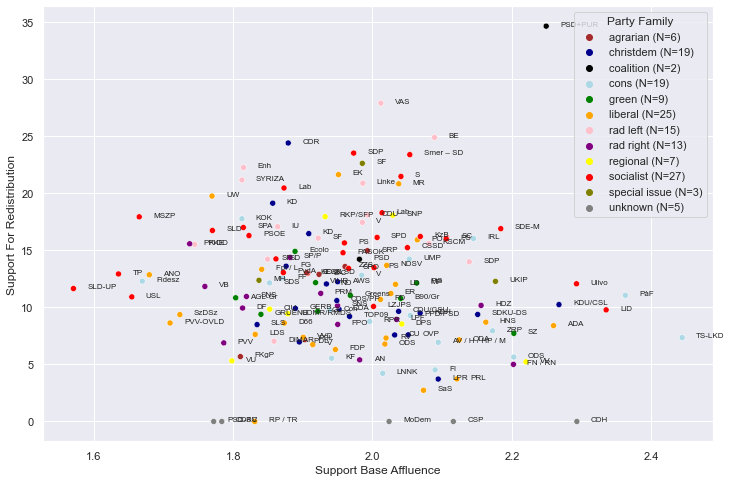

In [29]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = df,x=x_axis,y=y_axis,
                hue="Party Family",palette=party_colour_dict);
# ,palette=party_colour_dict
# make size = percentage of the vote? "pervote"

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=8)

label_point(df[x_axis],
            df[y_axis],
            df["Abbreviation"], plt.gca())

# plt.xlabel("Support Base Affluence");
# plt.ylabel("Support For Redistribution");
# plt.gca().legend(title='Party Family');

In [30]:

# colours = mps["party"].replace(party_colour_dict).values
colors = factor_cmap('Party Family', palette=list(party_colour_dict.values()), factors=list(party_colour_dict.keys()))

hover = HoverTool(tooltips = [('name','@partyname'),
                              ('abbrev','@abbrev'),
                              ('party family','@{Party Family}'),
                              ('country','@country'),
#                               ('date','@date'),
                              ('right-left','@rile'),
                              ('planned economy','@planeco'),
                              ('market economy','@markeco'),
                              ('welfare','@welfare'),
                              ('intpeace','@intpeace')])

p1 = figure(plot_width=950, plot_height=400, title="Party Manifesto 'Redistributiveness' by Mean Electorate Income Decile",
            tools='box_select,pan,wheel_zoom,box_zoom,reset,save', active_drag="box_select",
            x_axis_label = "Support Base Affluence",y_axis_label="Support For Redistribution",)
for family in df["Party Family"].cat.categories:
    mask = df["Party Family"]==family
    source = ColumnDataSource(df[mask])
    p1.scatter('Support Base Affluence', 'Support For Redistribution',source=source,
               fill_color=party_colour_dict[family], line_color = party_colour_dict[family], alpha=0.7,
               legend_label=family,size='pervote_smaller')
    
#     p1.scatter('weighted_income_deciles', 'manifesto_redist', source=source, fill_color=colors, line_color = colors, alpha=0.7,
#               legend_group='parfam',size='pervote_smaller',)
p1.add_tools(hover)
p1.legend.location = "top_left"
p1.legend.click_policy="hide"
show(p1)

In [31]:
left_wing_parties = ['green', 'liberal', 'rad left', 'socialist']
left_wing_parties = [k+" (N="+str(party_family_vc.loc[k])+")" for k in left_wing_parties]
title = "Figure 1: Party Manifesto 'Redistributiveness' by Mean Electorate Income Decile (Left-wing party families only)"

# colours = mps["party"].replace(party_colour_dict).values
colors = factor_cmap('Party Family', palette=list(party_colour_dict.values()), factors=list(party_colour_dict.keys()))

hover = HoverTool(tooltips = [('name','@partyname'),
                              ('abbrev','@abbrev'),
                              ('party family','@{Party Family}'),
                              ('country','@country'),
#                               ('date','@date'),
                              ('right-left','@rile'),
                              ('planned economy','@planeco'),
                              ('market economy','@markeco'),
                              ('welfare','@welfare'),
                              ('intpeace','@intpeace')])

p1 = figure(plot_width=950, plot_height=600, title=title,
            tools='box_select,tap,pan,wheel_zoom,box_zoom,reset,save', active_drag="box_select",
            x_axis_label = "Support Base Affluence",y_axis_label="Support For Redistribution",)
for family in left_wing_parties:
    mask = df["Party Family"]==family
    source = ColumnDataSource(df[mask])
    p1.scatter('Support Base Affluence', 'Support For Redistribution',source=source,
               fill_color=party_colour_dict[family], line_color = party_colour_dict[family], alpha=0.7,
               legend_label=family,size='pervote_smaller')
    
#     p1.scatter('weighted_income_deciles', 'manifesto_redist', source=source, fill_color=colors, line_color = colors, alpha=0.7,
#               legend_group='parfam',size='pervote_smaller',)
p1.add_tools(hover)
p1.legend.location = "top_left"
p1.legend.click_policy="hide"
show(p1)

In [32]:
# left_wing_parties = ['green', 'liberal', 'rad left', 'socialist']
# left_wing_parties = [k+" (N="+str(party_family_vc.loc[k])+")" for k in left_wing_parties]
# title = "Party Manifesto 'Redistributiveness' by Mean Electorate Income Decile (Left-wing party families only)"

# # colours = mps["party"].replace(party_colour_dict).values
# colors = factor_cmap('Party Family', palette=list(party_colour_dict.values()), factors=list(party_colour_dict.keys()))

# hover = HoverTool(tooltips = [('name','@partyname'),
#                               ('abbrev','@abbrev'),
#                               ('party family','@{Party Family}'),
#                               ('country','@country'),
# #                               ('date','@date'),
#                               ('right-left','@rile'),
#                               ('planned economy','@planeco'),
#                               ('market economy','@markeco'),
#                               ('welfare','@welfare'),
#                               ('intpeace','@intpeace')])

# p1 = figure(plot_width=1900, plot_height=800, title=title,
#             tools='box_select,tap,pan,wheel_zoom,box_zoom,reset,save', active_drag="box_select",
#             x_axis_label = "Support Base Affluence",y_axis_label="Support For Redistribution",)
# for family in left_wing_parties:
#     mask = df["Party Family"]==family
#     source = ColumnDataSource(df[mask])
#     p1.scatter('Support Base Affluence', 'Support For Redistribution',source=source,
#                fill_color=party_colour_dict[family], line_color = party_colour_dict[family], alpha=0.7,
#                legend_label=family,size='pervote_smaller')
    
# #     p1.scatter('weighted_income_deciles', 'manifesto_redist', source=source, fill_color=colors, line_color = colors, alpha=0.7,
# #               legend_group='parfam',size='pervote_smaller',)
# p1.add_tools(hover)
# p1.legend.location = "top_left"
# p1.legend.click_policy="hide"
# show(p1)

In [33]:
from bokeh.io import export_png
from bokeh.io import export_svgs
from bokeh.io.export import get_screenshot_as_png

# export_png(p1, filename=r'C:\MyImage.png')

In [34]:
export_png(p1, filename=r'C:\Figure1.png')

'C:\\Figure1.png'

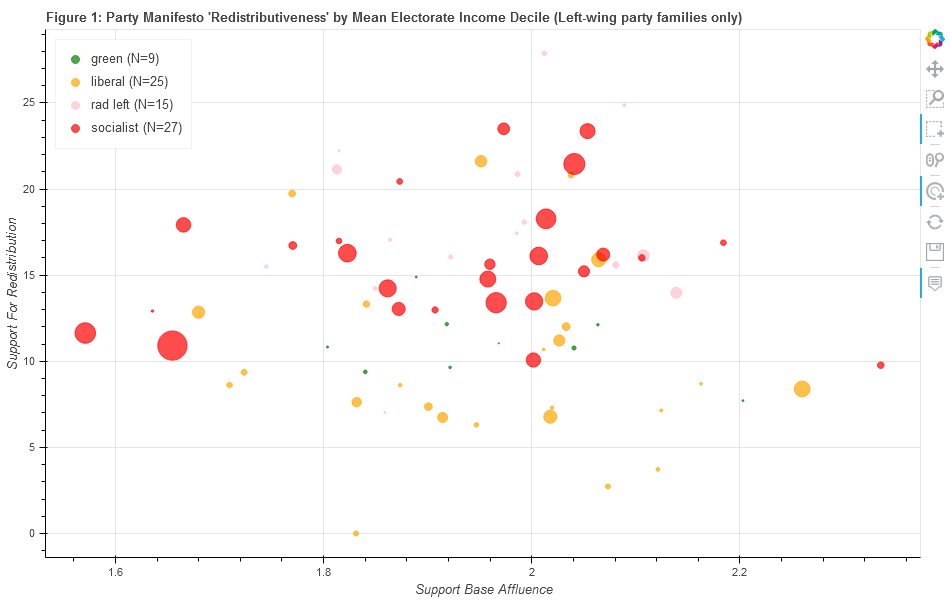

In [35]:
from bokeh.io.export import get_screenshot_as_png
# width=950
# height=400
image = get_screenshot_as_png(p1)
image

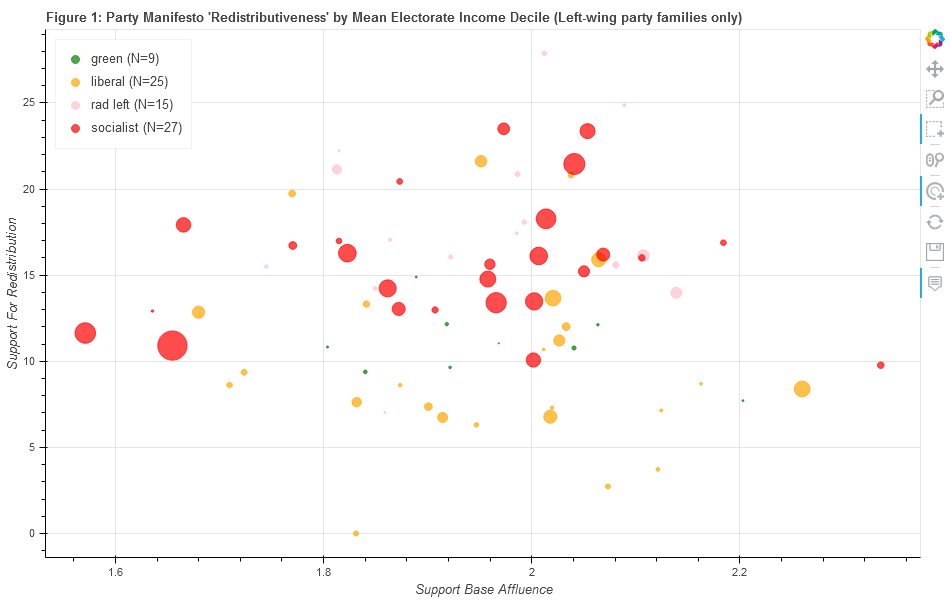

In [36]:
image

In [37]:
from bokeh.io import export_svgs

p1.output_backend = "svg"
export_svgs(p1, filename=r'C:\MyImage3.svg')

['C:\\MyImage3.svg']

In [38]:
left_wing_parties = ['green', 'liberal', 'rad left', 'socialist']
left_wing_parties = [k+" (N="+str(party_family_vc.loc[k])+")" for k in left_wing_parties]
title = "Party Manifesto 'Redistributiveness' by Mean Electorate Income Decile (Left-wing party families only)"

# colours = mps["party"].replace(party_colour_dict).values
colors = factor_cmap('Party Family', palette=list(party_colour_dict.values()), factors=list(party_colour_dict.keys()))

hover = HoverTool(tooltips = [('name','@partyname'),
                              ('abbrev','@abbrev'),
                              ('party family','@{Party Family}'),
                              ('country','@country'),
#                               ('date','@date'),
                              ('right-left','@rile'),
                              ('planned economy','@planeco'),
                              ('market economy','@markeco'),
                              ('welfare','@welfare'),
                              ('intpeace','@intpeace')])

p1 = figure(plot_width=950, plot_height=400, title=title,
            tools='box_select,tap,pan,wheel_zoom,box_zoom,reset,save', active_drag="box_select",
            x_axis_label = "Support Base Affluence",y_axis_label="Support For Redistribution",)
for family in left_wing_parties:
    mask = df["Party Family"]==family
    source = ColumnDataSource(df[mask])
    p1.scatter('Support Base Affluence', 'Support For Redistribution',source=source,
               fill_color=party_colour_dict[family], line_color = party_colour_dict[family], alpha=0.7,
               legend_label=family,size='pervote_smaller')
    
#     p1.scatter('weighted_income_deciles', 'manifesto_redist', source=source, fill_color=colors, line_color = colors, alpha=0.7,
#               legend_group='parfam',size='pervote_smaller',)
p1.add_tools(hover)
p1.legend.location = "top_left"
p1.legend.click_policy="hide"
# canvas, svg, webgl
p1.output_backend = "svg"
p1.background_fill_color = None
p1.border_fill_color = None
show(p1)

In [39]:
table_output_dir = dataset_folder + os.sep + "Redistribution_vs_Electorate Income Chart subset" + os.sep

In [40]:
## save png with 'save' tool on right hand side (because it automatically excludes the toolbar!)

from PIL import Image
fn = "Figure1"
image = Image.open(table_output_dir+fn+".png")
fill_color = '#ffffff'  # your background
if image.mode in ('RGBA', 'LA'):
    background = Image.new(image.mode[:-1], image.size, fill_color)
    background.paste(image, image.split()[-1])
    image = background
# image.save(table_output_dir+fn+".jpg",quality=95)

In [41]:
## save png with 'save' tool on right hand side (because it automatically excludes the toolbar!)

from PIL import Image
fn = "Figure1"
image = Image.open(table_output_dir+fn+".svg")
fill_color = '#ffffff'  # your background
if image.mode in ('RGBA', 'LA'):
    background = Image.new(image.mode[:-1], image.size, fill_color)
    background.paste(image, image.split()[-1])
    image = background
# image.save(table_output_dir+fn+".eps")

UnidentifiedImageError: cannot identify image file 'C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\datasets\\\\Redistribution_vs_Electorate Income Chart subset\\Figure1.svg'

In [47]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM, renderPS
drawing = svg2rlg(table_output_dir+fn+".svg")

renderPS.drawToFile(drawing, table_output_dir+fn+".eps")

Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetica'
Unable to find a suitable font for 'font-family:helvetic

In [42]:
# table_output_dir = dataset_folder + os.sep + "Redistribution_vs_Electorate Income Chart subset" + os.sep
table_output_dir

'C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\datasets\\\\Redistribution_vs_Electorate Income Chart subset\\'

In [ ]:
## saving for dissemination/use in papers as: "Redistribution_vs_Electorate Income Chart subset"
## Version .0.1

# df.to_csv(table_output_dir+"full_table.csv")
# df[mask].to_csv(table_output_dir+"left_wing_table.csv")

In [ ]:
## try to build a version of this chart with

## (1) Save to CSV
## (2) Free selection of individual parties

In [ ]:
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.models.widgets import Button
from bokeh.io import show
import os

source = ColumnDataSource({'list1':[0,1,2,3],'list2':[4,5,6,7]})
button = Button(label="Download", button_type="success")
button.js_on_click(CustomJS(args=dict(source=source),
                            code="""function table_to_csv(source) {
    const columns = Object.keys(source.data)
    const nrows = source.get_length()
    const lines = [columns.join(',')]

    for (let i = 0; i < nrows; i++) {
        let row = [];
        for (let j = 0; j < columns.length; j++) {
            const column = columns[j]
            row.push(source.data[column][i].toString())
        }
        lines.push(row.join(','))
    }
    return lines.join('\n').concat('\n')
}


const filename = 'data_result.csv'
const filetext = table_to_csv(source)
const blob = new Blob([filetext], { type: 'text/csv;charset=utf-8;' })

//addresses IE
if (navigator.msSaveBlob) {
    navigator.msSaveBlob(blob, filename)
} else {
    const link = document.createElement('a')
    link.href = URL.createObjectURL(blob)
    link.download = filename
    link.target = '_blank'
    link.style.visibility = 'hidden'
    link.dispatchEvent(new MouseEvent('click'))
}"""
                            
                            #open(os.path.join(os.path.dirname(__file__),"download.js")).read()
                           
                           
                           ))
show(button)

In [ ]:
# Generate linked plots + TABLE displaying data + save button to export cvs of selected data

from random import random

from bokeh.io import output_notebook  # prevent opening separate tab with graph
from bokeh.io import show

from bokeh.layouts import row
from bokeh.layouts import grid
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.models import Button  # for saving data
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.models import HoverTool
from bokeh.plotting import figure


# create data
x = [random() for x in range(500)]
y = [random() for y in range(500)]

# create first subplot
plot_width = 400
plot_height = 400

s1 = ColumnDataSource(data=dict(x=x, y=y))
fig01 = figure(
    plot_width=plot_width,
    plot_height=plot_height,
    tools=["lasso_select", "tap","reset", "save"],
    title="Select Here",
)
fig01.circle("x", "y", source=s1, alpha=0.6)

# create second subplot
s2 = ColumnDataSource(data=dict(x=[], y=[]))

# demo smart error msg:  `box_zoom`, vs `BoxZoomTool`
fig02 = figure(
    plot_width=400,
    plot_height=400,
    x_range=(0, 1),
    y_range=(0, 1),
    tools=["box_zoom", "wheel_zoom", "reset", "save"],
    title="Watch Here",
)

fig02.circle("x", "y", source=s2, alpha=0.6, color="firebrick")

# create dynamic table of selected points
columns = [
    TableColumn(field="x", title="X axis"),
    TableColumn(field="y", title="Y axis"),
]

table = DataTable(
    source=s2,
    columns=columns,
    width=400,
    height=600,
    sortable=True,
    selectable=True,
    editable=True,
)

# fancy javascript to link subplots
# js pushes selected points into ColumnDataSource of 2nd plot
# inspiration for this from a few sources:
# credit: https://stackoverflow.com/users/1097752/iolsmit via: https://stackoverflow.com/questions/48982260/bokeh-lasso-select-to-table-update
# credit: https://stackoverflow.com/users/8412027/joris via: https://stackoverflow.com/questions/34164587/get-selected-data-contained-within-box-select-tool-in-bokeh

s1.selected.js_on_change(
    "indices",
    CustomJS(
        args=dict(s1=s1, s2=s2, table=table),
        code="""
        var inds = cb_obj.indices;
        var d1 = s1.data;
        var d2 = s2.data;
        d2['x'] = []
        d2['y'] = []
        for (var i = 0; i < inds.length; i++) {
            d2['x'].push(d1['x'][inds[i]])
            d2['y'].push(d1['y'][inds[i]])
        }
        s2.change.emit();
        table.change.emit();

        var inds = source_data.selected.indices;
        var data = source_data.data;
        var out = "x, y\\n";
        for (i = 0; i < inds.length; i++) {
            out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "\\n";
        }
        var file = new Blob([out], {type: 'text/plain'});

    """,
    ),
)

# create save button - saves selected datapoints to text file onbutton
# inspriation for this code:
# credit:  https://stackoverflow.com/questions/31824124/is-there-a-way-to-save-bokeh-data-table-content
# note: savebutton line `var out = "x, y\\n";` defines the header of the exported file, helpful to have a header for downstream processing

savebutton = Button(label="Save", button_type="success")
savebutton.callback = CustomJS(
    args=dict(source_data=s1),
    code="""
        var inds = source_data.selected.indices;
        var data = source_data.data;
        var out = "x, y\\n";
        for (i = 0; i < inds.length; i++) {
            out += data['x'][inds[i]] + "," + data['y'][inds[i]] + "\\n";
        }
        var file = new Blob([out], {type: 'text/plain'});
        var elem = window.document.createElement('a');
        elem.href = window.URL.createObjectURL(file);
        elem.download = 'selected-data.csv';
        document.body.appendChild(elem);
        elem.click();
        document.body.removeChild(elem);
        """,
)

# add Hover tool
# define what is displayed in the tooltip
tooltips = [
    ("X:", "@x"),
    ("Y:", "@y"),
    ("static text", "static text"),
]

fig02.add_tools(HoverTool(tooltips=tooltips))

# display results
# demo linked plots
# demo zooms and reset
# demo hover tool
# demo table
# demo save selected results to file

layout = grid([fig01, fig02, table, savebutton], ncols=3)

output_notebook()
show(layout)

# things to try:
# select random shape of blue dots with lasso tool in 'Select Here' graph
# only selected points appear as red dots in 'Watch Here' graph -- try zooming, saving that graph separately
# selected points also appear in the table, which is sortable
# click the 'Save' button to export a csv

# TODO:  export from Bokeh to pandas dataframe

In [ ]:
plt.figure(figsize=(12,8))
# df_merged["Party Family"] = party_family.fillna("unknown").astype('category')
sns.kdeplot( data = df,
             x = "Support Base Affluence",
             hue="Party Family",
             palette = party_colour_dict,
             cut=0);

In [ ]:
plt.figure(figsize=(12,8))
# df_merged["Party Family"] = party_family.fillna("unknown").astype('category')
sns.kdeplot( data = df,
             x = "Support Base Affluence",
             hue="Party Family",
             palette = party_colour_dict,
             cut=0,multiple='stack');


In [ ]:
plt.figure(figsize=(12,8))
# df_merged["Party Family"] = party_family.fillna("unknown").astype('category')
sns.kdeplot( data = df,
             x = "Support Base Affluence",
             hue="Party Family",
             palette = party_colour_dict,
             cut=0,multiple='fill');


In [ ]:
### Hmm - I wonder how different it would be if you looked at individual voters rather than party means?

# have to load the full respondent dataset


In [ ]:
resp_df = pd.read_pickle(dataset_folder + "CSES"+os.sep+"Integration"+os.sep+"resp_df.pkl")

In [ ]:
# search(resp_df,"partyfacts")

In [ ]:
# resp_df["IMD2006_ORD"].value_counts()

In [ ]:
mask = resp_df["IMD2006_ORD"].notnull()&resp_df["highest_freq_party_ref"].notnull()&resp_df["highest_freq_party_ref"].apply(lambda x: x in list(party_family.index))

respondent_favoured_party = resp_df["highest_freq_party_ref"][mask]
respondent_income_quintile = resp_df["IMD2006_ORD"][mask]


In [ ]:
respondent_inc_quin_by_party_family = pd.concat([respondent_favoured_party,respondent_income_quintile],axis=1)
respondent_inc_quin_by_party_family["highest_freq_party_ref"] = respondent_inc_quin_by_party_family["highest_freq_party_ref"].apply(lambda x:party_family.loc[x])

In [ ]:
resp_inc_label="income quintile (1-5)"
resp_party_label = "party family"
respondent_inc_quin_by_party_family = respondent_inc_quin_by_party_family\
                                .rename(columns ={"highest_freq_party_ref":resp_party_label,"IMD2006_ORD":resp_inc_label})
respondent_inc_quin_by_party_family["weights"] = resp_df["IMD1010_1_MET"][mask]
respondent_inc_quin_by_party_family[resp_inc_label] = respondent_inc_quin_by_party_family[resp_inc_label].astype(int)+1

In [ ]:
## raw count - no weighting!
# what's the laziest way to add semi-reasonable weights here?

# sns.countplot(data=respondent_inc_quin_by_party_family,hue=resp_inc_label,x=resp_party_label)
# plt.xticks(rotation=45);

In [ ]:
ct = pd.crosstab(respondent_inc_quin_by_party_family[resp_inc_label],
            respondent_inc_quin_by_party_family[resp_party_label],
            aggfunc=sum,values=respondent_inc_quin_by_party_family["weights"],
            normalize='columns'
           )*100

In [ ]:
plt.figure(figsize = (12,8));
sns.barplot(data=ct.reset_index().melt(id_vars = resp_inc_label,value_name="%"),
            x = resp_party_label,
            hue = resp_inc_label,
            y="%");
plt.xticks(rotation=45);

In [ ]:
## Not sure what the takehome is here
# maybe means aren't the best summary for support base affluence
# maybe they are, but you still want to think about the broader distribution?

# very rough stuff - goodness knows what sort of weird effects you get from jamming parties together like this are

# also, always important to remember that income != wealth

In [ ]:
### two things I'd like to add

# (1) holoviews for just browsing the dataset (is that space realistic???)
# (2) a very basic view with shifts over time
#    I don't quite want to engage with linking datasets with different distributions
#    

In [ ]:
resp_df_count_partyear = pd.read_pickle(dataset_folder + "CSES"+os.sep+"Integration"+os.sep+"respond_sample_broad_count_ptryr.pkl").drop("index",axis=1)

In [ ]:
resp_df_mean_partyear = pd.read_pickle(dataset_folder + "CSES"+os.sep+"Integration"+os.sep+"respond_sample_broad_mean_ptryr.pkl").drop("index",axis=1)

In [ ]:
resp_df_mean_partyear = resp_df_mean_partyear.set_index(["partyfacts_id","year"])

# messy extra index

In [ ]:
party_level = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df.zip",compression='zip')

In [ ]:
party_level = party_level.set_index(["partyfacts_id","year"])

In [ ]:
party_year_overlap = list( set(resp_df_mean_partyear.index).intersection(party_level.index) )

In [ ]:
len( party_year_overlap )

In [ ]:
resp_df_mean_partyear.loc[list(party_year_overlap)].sort_index().reset_index()["partyfacts_id"].value_counts()

In [ ]:
partyfacts_core_parties_newest.set_index("partyfacts_id").loc[1474]

In [ ]:
manifesto_redist = party_level[["(manifesto)per"+x for x in ["404","405","409","413","504","701"]]].sum(axis=1)
manifesto_redist[party_level[["(manifesto)per"+x for x in ["404","405","409","413","504","701"]]].isnull().all(axis=1)]=np.nan

## some duplicates partyfacts_id here, but the manifesto data is identical in each case, so just just drop duplicates
manifesto_redist = manifesto_redist.reset_index().drop_duplicates().set_index(["partyfacts_id","year"])[0]
party_family = party_level["(manifesto)family"].dropna()
# party_level[search(party_level,"\(manifesto\)family").index].dropna().idxmax(axis=1).apply(lambda x: x.replace("(manifesto)family__","") if pd.notnull(x) else np.nan)
# party_family = party_family.reset_index().drop_duplicates().set_index("partyfacts_id")[0]

In [ ]:
party_year_overlap = manifesto_redist.loc[party_year_overlap][manifesto_redist.loc[party_year_overlap].notnull()].index
# manifesto_redist.loc[party_year_overlap].isnull().sum()

In [ ]:
party_family

In [ ]:
manifesto_redist.loc[party_year_overlap].dropna()
# manifesto_redist.loc[party_year_overlap].isnull().sum()

In [ ]:
manifesto_redist.loc[party_year_overlap].dropna()

In [ ]:
# search(resp_df_mean_partyear,"IMD2006")

party_year_overlap = resp_df_mean_partyear.loc[party_year_overlap][resp_df_mean_partyear.loc[party_year_overlap,"IMD2006_ORD"].notnull()].index


In [ ]:
resp_df_mean_partyear.loc[ party_year_overlap ].reset_index()["year"].value_counts().sort_index()

In [ ]:
resp_df_mean_partyear.loc[ party_year_overlap ].reset_index()["partyfacts_id"].value_counts().sort_values()

In [ ]:
parties_with_5_plus_refs = resp_df_mean_partyear.loc[ party_year_overlap ].reset_index()["partyfacts_id"].value_counts()[ resp_df_mean_partyear.loc[ party_year_overlap ].reset_index()["partyfacts_id"].value_counts()>=5 ].index

In [ ]:
parties_with_5_plus_refs

In [ ]:
resp_df_mean_partyear.loc[parties_with_5_plus_refs,:].reset_index()["year"].value_counts()

In [ ]:
parties_with_5_plus_refs

In [ ]:
party_year_overlap_small = manifesto_redist.loc[ party_year_overlap ].dropna().loc[parties_with_5_plus_refs,:].index

In [ ]:
income_by_party_redist_year_party = manifesto_redist.loc[ party_year_overlap_small ].dropna().reset_index().merge(resp_df_mean_partyear.loc[ party_year_overlap_small ,"IMD2006_ORD"].reset_index(),on=["partyfacts_id","year"],how='left')
income_by_party_redist_year_party = income_by_party_redist_year_party.rename(columns = {"IMD2006_ORD":x_axis,0:y_axis})
income_by_party_redist_year_party["partyfacts_id"] = income_by_party_redist_year_party["partyfacts_id"].astype(int)
income_by_party_redist_year_party["Abbreviation"] = income_by_party_redist_year_party["partyfacts_id"].apply(lambda x: abbreviation.loc[x])

In [ ]:
party_family = party_family.reset_index().drop_duplicates().set_index(["partyfacts_id","year"])

In [ ]:
income_by_party_redist_year_party["Party Family"] = party_family.loc[ income_by_party_redist_year_party.set_index(["partyfacts_id","year"]).index ].values

In [ ]:
income_by_party_redist_year_party["Party Family"] = income_by_party_redist_year_party["Party Family"].astype('category')

In [ ]:
income_by_party_redist_year_party["year"] = income_by_party_redist_year_party["year"].astype('category')

In [ ]:
party_colour_dict = {k.split(" (")[0]:v for k,v in party_colour_dict.items()}

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = income_by_party_redist_year_party,x=x_axis,y=y_axis,
                hue="Party Family",palette=party_colour_dict);
# ,palette=party_colour_dict
# make size = percentage of the vote? "pervote"

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=8)

label_point(income_by_party_redist_year_party[x_axis],
            income_by_party_redist_year_party[y_axis],
            income_by_party_redist_year_party["Abbreviation"], plt.gca())

# plt.xlabel("Support Base Affluence");
# plt.ylabel("Support For Redistribution");
# plt.gca().legend(title='Party Family');

In [ ]:
income_by_party_redist_year_party["year"] = income_by_party_redist_year_party["year"].astype(str).astype('category')

In [ ]:
income_by_party_redist_year_party["partyname"] = partyfacts_core_parties_newest.set_index("partyfacts_id")["name_english"].loc[income_by_party_redist_year_party["partyfacts_id"]].values
income_by_party_redist_year_party["partyname"] = income_by_party_redist_year_party["partyname"].astype('category')

In [ ]:
spec_party_colour_dict = dict( zip( income_by_party_redist_year_party["country_abbrev"].cat.categories, cycle(list(party_colour_dict.values())) ) )

In [ ]:
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
# colours = mps["party"].replace(party_colour_dict).values
# colors = factor_cmap('year', palette=list(party_colour_dict.values()), factors=list(party_colour_dict.keys()))
colors = factor_cmap('year', palette=list(spec_party_colour_dict.values()), factors=list(spec_party_colour_dict.keys()))

hover = HoverTool(tooltips = [('name','@partyname'),
                              ('abbrev','@abbrev'),
                              ('year','@year'),
                              ('party family','@{Party Family}'),
#                             ('country','@country'),
                              ('abbrev','@Abbreviation'),
                              ('N = ','@{sample size}'),
#                               ('right-left','@rile'),
#                               ('planned economy','@planeco'),
#                               ('market economy','@markeco'),
#                               ('welfare','@welfare'),
#                               ('intpeace','@intpeace')
                             ])

p1 = figure(plot_width=950, plot_height=800, title="Party Manifesto 'Redistributiveness' by Mean Electorate Income Decile",
            tools='box_select,pan,wheel_zoom,box_zoom,reset', active_drag="box_select",
            x_axis_label = "Support Base Affluence",y_axis_label="Support For Redistribution",)
for family in income_by_party_redist_year_party["country_abbrev"].cat.categories:
    if family[0:3]!="DEU":
        continue
    mask = income_by_party_redist_year_party["country_abbrev"]==family
    source = ColumnDataSource(income_by_party_redist_year_party[mask])
    p1.scatter('Support Base Affluence', 'Support For Redistribution',source=source,
                alpha=0.7,line_color = spec_party_colour_dict[family], fill_color=spec_party_colour_dict[family],
               legend_label=family)

    labels = LabelSet(x=x_axis, y=y_axis, text='year', level='glyph',
             x_offset=0, y_offset=0, source=source)

    p1.add_layout(labels)
# source = ColumnDataSource(income_by_party_redist_year_party)
# p1.scatter('Support Base Affluence', 'Support For Redistribution',source=source,
#             alpha=0.7
# #            ,line_color = year_colour_dict[family], fill_color=year_colour_dict[family],
# #            legend_label=family
#           )
#     #,size='pervote_smaller')
    #
#     
    
#     p1.scatter('weighted_income_deciles', 'manifesto_redist', source=source, fill_color=colors, line_color = colors, alpha=0.7,
#               legend_group='parfam',size='pervote_smaller',)

p1.add_tools(hover)
p1.legend.location = "top_left"
p1.legend.click_policy="hide"
show(p1)

In [ ]:
partyfacts_core_parties_newest["country_abbrev"] =partyfacts_core_parties_newest["country"]+":"+partyfacts_core_parties_newest["name_short"]

In [ ]:
income_by_party_redist_year_party["country_abbrev"] = partyfacts_core_parties_newest.set_index("partyfacts_id")["country_abbrev"].loc[income_by_party_redist_year_party["partyfacts_id"]].values
income_by_party_redist_year_party["country_abbrev"] = income_by_party_redist_year_party["country_abbrev"].astype('category')

In [ ]:
income_by_party_redist_year_party["country_abbrev"].value_counts()

In [ ]:
# Sample size!

In [ ]:
resp_df_count_partyear.set_index(["partyfacts_id","year"]).loc[party_year_overlap_small]["IMD2006_ORD"].astype(int).reset_index()
#["partyfacts_id","year","IMD2006_ORD"].astype(int)

In [ ]:
income_by_party_redist_year_party = income_by_party_redist_year_party.merge(resp_df_count_partyear.set_index(["partyfacts_id","year"]).loc[party_year_overlap_small]["IMD2006_ORD"].astype(int).reset_index(),
                                                                           how='left',on=["partyfacts_id","year"])\
                                                                        .rename(columns = {"IMD2006_ORD":"sample size"})

In [ ]:
### Hmm - maybe the cmp redistribution measure ... just sucks?
### lets see if we can quickly try the same thing for a different one - e.g. CHES's "redist" measure

In [ ]:
search(party_level,"redist")

In [ ]:
ches_redist = 1-party_level["(ches)redist"]

In [ ]:
party_year_overlap = list( set(resp_df_mean_partyear.index).intersection(party_level.index) )
party_year_overlap = ches_redist.loc[party_year_overlap].dropna().index
party_year_overlap = resp_df_mean_partyear.loc[party_year_overlap,"IMD2006_ORD"].dropna().index

In [ ]:
# party_year_overlap

In [ ]:
# search(party_level,"\(ches\)").sort_values(ascending=False).head(50)

In [ ]:
# party_level["(ches)family"]

In [ ]:
income_by_party_redist_year_party = ches_redist.loc[ party_year_overlap ].dropna().reset_index().merge(resp_df_mean_partyear.loc[ party_year_overlap ,"IMD2006_ORD"].reset_index(),on=["partyfacts_id","year"],how='left')
income_by_party_redist_year_party = income_by_party_redist_year_party.rename(columns = {"IMD2006_ORD":x_axis,"(ches)redist":y_axis})
income_by_party_redist_year_party["partyfacts_id"] = income_by_party_redist_year_party["partyfacts_id"].astype(int)
income_by_party_redist_year_party["Abbreviation"] = income_by_party_redist_year_party["partyfacts_id"].apply(lambda x: abbreviation.loc[x])
income_by_party_redist_year_party["Party L-R"] = party_level.loc[party_year_overlap,"(ches)lrgen"].dropna().values

In [ ]:
income_by_party_redist_year_party

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = income_by_party_redist_year_party,x=x_axis,y=y_axis,
                hue="Party L-R");
#,palette=party_colour_dict
# ,palette=party_colour_dict
# make size = percentage of the vote? "pervote"

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=8)

label_point(income_by_party_redist_year_party[x_axis],
            income_by_party_redist_year_party[y_axis],
            income_by_party_redist_year_party["Abbreviation"], plt.gca())

# plt.xlabel("Support Base Affluence");
# plt.ylabel("Support For Redistribution");
# plt.gca().legend(title='Party Family');

In [ ]:
# party_level.loc[party_year_overlap,"(ches)lrgen"].dropna().index==party_year_overlap

In [ ]:
income_by_party_redist_year_party